<a id="tabla_contenidos"></a> 
## Tabla de Contenidos

### <a href='#0'>0. Importamos las librerias</a>

### <a href='#1'>1. Levantamos la base de datos</a>

### <a href='#2'>2. Limpiamos la base</a>

### <a href='#3'>3. Armado del modelo de recomendacion</a>

* #### <a href='#3.1'>3.1. Armado del modelo</a>

### <a href='#4'>4. Optimizamos modelos</a>
* #### <a href='#4.1'>4.1. Optimizamos hiperparametros SVD</a>
* #### <a href='#4.2'>4.2. Optimizamos hiperparametros NMF</a>
* #### <a href='#4.3'>4.3. Optimizamos hiperparametros KNNBasic</a>

### <a href='#5'>5. Recomendaciones</a>
* #### <a href='#5.1'>5.1. Recomendaciones por ID</a>


<a id="0"></a> 
## 0. Importamos las librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import surprise modules
from surprise import Dataset
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import RandomizedSearchCV

from surprise import SVD, SVDpp, NMF, SlopeOne, CoClustering, KNNBaseline, KNNWithZScore, KNNWithMeans, KNNBasic, BaselineOnly, NormalPredictor
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import pickle

<a id="1"></a> 
## 1. Levantamos la base de datos

In [2]:
df = pd.read_csv('Data/data_recomendation.csv')

C:\Users\Administrator\anaconda3\envs\dhdsblend\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (6,9,12,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(df.shape)
df.head()

(2470400, 49)


,Unnamed: 0,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,14,2015-01-28,1050625,N,ES,V,23,2012-08-10,0.0,35,...,0,0,0,0,0,0,0,0.0,0.0,0
1,15,2015-01-28,1050626,N,ES,V,23,2012-08-10,0.0,35,...,0,0,0,0,0,0,0,0.0,0.0,0
2,16,2015-01-28,1050610,N,ES,V,24,2012-08-10,0.0,35,...,0,0,0,0,0,0,0,0.0,0.0,0
3,22,2015-01-28,1050588,N,ES,H,22,2012-08-10,0.0,35,...,0,0,0,0,0,0,0,0.0,0.0,0
4,25,2015-01-28,1050592,N,ES,H,22,2012-08-10,0.0,35,...,0,0,0,0,0,0,0,0.0,0.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470400 entries, 0 to 2470399
Data columns (total 49 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   fecha_dato             object 
 2   ncodpers               int64  
 3   ind_empleado           object 
 4   pais_residencia        object 
 5   sexo                   object 
 6   age                    object 
 7   fecha_alta             object 
 8   ind_nuevo              float64
 9   antiguedad             object 
 10  indrel                 float64
 11  ult_fec_cli_1t         object 
 12  indrel_1mes            object 
 13  tiprel_1mes            object 
 14  indresi                object 
 15  indext                 object 
 16  conyuemp               object 
 17  canal_entrada          object 
 18  indfall                object 
 19  tipodom                float64
 20  cod_prov               float64
 21  nomprov                object 
 22  ind_actividad_clie

<a id="2"></a> 
## 2. Limpiamos la base

In [5]:
df.pais_residencia.value_counts()

ES    2453754
DE        948
AR        857
CO        832
FR        816
       ...   
KE         13
EE         11
ZW         11
BM          6
HU          1
Name: pais_residencia, Length: 77, dtype: int64

   * Vamos a filtrar solo a aquellos individuos de España  

In [6]:
df=df[df['pais_residencia']=='ES']

In [7]:
print(df.shape)

(2453754, 49)


   * Vamos a filtrar solo a aquellos "No Empleados"

In [8]:
df=df[df['ind_empleado']=='N']
print(df.shape)

(2452266, 49)


   * Vamos a filtrar solo a aquellos cliente "No Fallecidos"

In [9]:
df=df[df['indfall']=='N']
print(df.shape)

(2445694, 49)


   * Vamos a filtrar solo a aquellos cliente en Activos

In [10]:
df.ind_actividad_cliente.value_counts()

0.0    1324305
1.0    1121389
Name: ind_actividad_cliente, dtype: int64

In [11]:
df=df[df['ind_actividad_cliente']==1]

In [12]:
df.shape

(1121389, 49)

In [13]:
df=df[['ncodpers','ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
           'ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1',
           'ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
           'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1']]

In [14]:
df=df.groupby(['ncodpers'], as_index=False)[
    'ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
           'ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1',
           'ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
           'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1'].agg('sum')

C:\Users\Administrator\anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [15]:
print(df.shape)
df.head()

(78101, 22)


,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,...,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1
0,15893,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,17,0
1,15932,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,17,0
2,16031,0,0,17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16039,0,0,0,0,17,0,0,0,17,...,17,0,17,17,17,0,0,17,0,0
4,16047,0,0,17,0,17,0,0,0,0,...,0,0,0,0,0,0,0,17,0,0


In [16]:
df2=df.sample(frac=0.05, replace=True, random_state=1)
print(df2.shape)
df2.head()

(3905, 22)


,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,...,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1
77708,1546018,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5192,120258,0,0,17,0,0,0,0,17,0,...,0,0,0,0,0,0,0,0,0,0
50057,1135989,0,0,17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73349,1490310,0,0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21440,453639,0,0,17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id="3"></a> 
## 3. Armado del modelo de recomendacion

#### Vamos a crear una base con el nombre del producto

In [17]:
productos=['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
           'ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1',
           'ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
           'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1']

In [18]:
diccionario={productos[0]:'Caja de Ahorro',productos[1]:'Garantias',productos[2]:'Cuenta Corriente', 
      productos[3]:'Cuenta de Derivados', productos[4]:'Cuenta Sueldo', productos[5]:'Cuenta Joven',
      productos[6]:'Cuenta Particular Basica', productos[7]:'Cuenta Particular', productos[8]:'Cuenta Particular Plus',
      productos[9]:'Depositos a Corto Plazo', productos[10]:'Depositos a Mediano Plazo', productos[11]:'Depositos a Largo Plazo',
      productos[12]:'Cuenta Electronica', productos[13]:'Fondos Comunes de Inversion', productos[14]:'Prestamo Hipotecario',
      productos[15]:'Plan de Pensiones', productos[16]:'Prestamos', productos[17]:'Cuenta Impuestos/Recaudacion', 
      productos[18]:'Tarjeta de Credito', productos[19]:'Valores', productos[20]:'Cuenta de Vivienda'}

In [19]:
base_productos = pd.DataFrame([[key, diccionario[key]] for key in diccionario.keys()], columns=['id_prod', 'Producto'])
base_productos

,id_prod,Producto
0,ind_ahor_fin_ult1,Caja de Ahorro
1,ind_aval_fin_ult1,Garantias
2,ind_cco_fin_ult1,Cuenta Corriente
3,ind_cder_fin_ult1,Cuenta de Derivados
4,ind_cno_fin_ult1,Cuenta Sueldo
5,ind_ctju_fin_ult1,Cuenta Joven
6,ind_ctma_fin_ult1,Cuenta Particular Basica
7,ind_ctop_fin_ult1,Cuenta Particular
8,ind_ctpp_fin_ult1,Cuenta Particular Plus
9,ind_deco_fin_ult1,Depositos a Corto Plazo


#### Vamos a generar la base sobre la cual aplicar el modelo

In [20]:
df_prod=df2
df_prod.head()

,ncodpers,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,...,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1
77708,1546018,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5192,120258,0,0,17,0,0,0,0,17,0,...,0,0,0,0,0,0,0,0,0,0
50057,1135989,0,0,17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73349,1490310,0,0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21440,453639,0,0,17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df_prod=df_prod.set_index('ncodpers')
df_prod.head()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1
ncodpers,,,,,,,,,,,,,,,,,,,,,
1546018,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120258,0,0,17,0,0,0,0,17,0,0,...,0,0,0,0,0,0,0,0,0,0
1135989,0,0,17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1490310,0,0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
453639,0,0,17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_prod=pd.DataFrame(df_prod.stack())
df_prod=df_prod.reset_index()
df_prod.rename(columns={'level_1':'Producto',0:'Rating'},inplace=True)
df_prod.head()

,ncodpers,Producto,Rating
0,1546018,ind_ahor_fin_ult1,0
1,1546018,ind_aval_fin_ult1,0
2,1546018,ind_cco_fin_ult1,2
3,1546018,ind_cder_fin_ult1,0
4,1546018,ind_cno_fin_ult1,0


#### Vamos a eliminar las lineas que no tienen rating

In [23]:
df_prod=df_prod[df_prod['Rating']>0]
df_prod.head()

,ncodpers,Producto,Rating
2,1546018,ind_cco_fin_ult1,2
23,120258,ind_cco_fin_ult1,17
28,120258,ind_ctop_fin_ult1,17
44,1135989,ind_cco_fin_ult1,17
65,1490310,ind_cco_fin_ult1,7


In [24]:
df_prod.shape

(7717, 3)

### EDA

#### Ratings Distribution

In [25]:
import matplotlib as plt

In [26]:
a=pd.DataFrame(df_prod.Rating.value_counts()).reset_index()
a=a.sort_values(by=['index'])


In [27]:
a['index'] = a['index'].astype(str)

In [28]:
def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.4
        y = p.get_y() + p.get_height() 
        ax.annotate(percentage, (x, y), size = 10)
    plt.show()

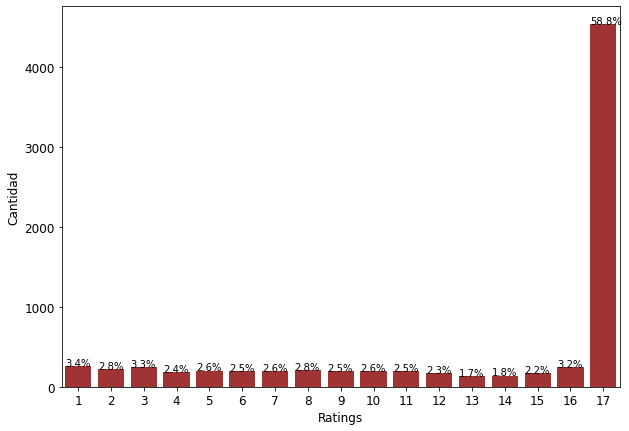

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
ax=sns.countplot('Rating', data=df_prod,color='firebrick')
# sns.color_palette("mako")
plt.xticks(size=12)
plt.xlabel('Ratings',size=12)
plt.yticks(size=12)
plt.ylabel('Cantidad',size=12)

without_hue(ax, df_prod['Rating'])

#### Generamos un diccionario de productos y usuarios

In [30]:
users = list(df_prod['ncodpers'].unique())
items = list(df_prod['Producto'].unique())

def movie_id_to_name(id):
    return base_productos.loc[base_productos['id_prod']==id].Producto
movie_id_to_name('ind_cco_fin_ult1')

2    Cuenta Corriente
Name: Producto, dtype: object

<a id="3.1"></a> 
### 3.1. Armado del modelo

In [31]:
# Specific reader for surpirse to work
reader = Reader(rating_scale= (df_prod['Rating'].min(),df_prod['Rating'].max()))
data_sp = Dataset.load_from_df(df_prod, reader=reader)

In [32]:
from surprise.model_selection import GridSearchCV,PredefinedKFold

In [44]:
algoritmos =  [SVD(), NMF(), BaselineOnly(), SlopeOne(), KNNBasic(), KNNWithZScore()]

names = [algoritmos[i].__class__.__name__ for i in range(len(algoritmos))]

result = np.zeros((len(algoritmos),4))            
for i in range(len(algoritmos)):
    print('Procesando ', names[i], '...')
    tab = cross_validate(algoritmos[i], data_sp,cv=5, verbose = False,n_jobs=-1)
    rmse = np.mean(tab['test_rmse']).round(3)
    mae = np.mean(tab['test_mae']).round(3)
    ft = np.mean(tab['fit_time']).round(3)
    tt = np.mean(tab['test_time']).round(3)
    result[i]=[rmse, mae
               , ft, tt
              ]
    
result = result.round(3)
result = pd.DataFrame(result, index = names, columns =['RMSE','MAE'
                                                       ,'fit_time','test_time'
                                                      ])

Procesando  SVD ...
Procesando  NMF ...
Procesando  BaselineOnly ...
Procesando  SlopeOne ...
Procesando  KNNBasic ...
Procesando  KNNWithZScore ...


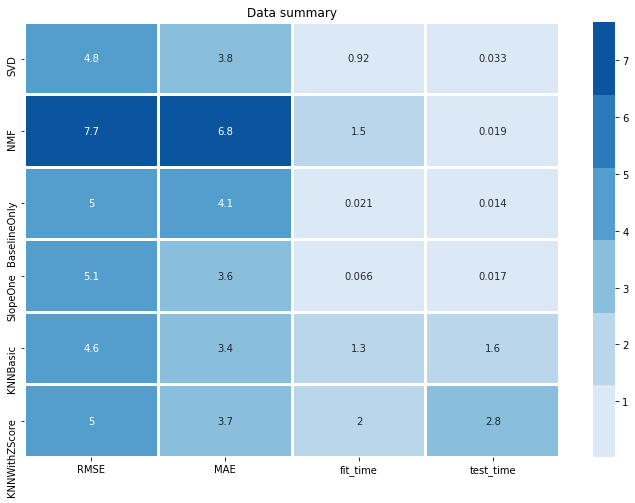

In [34]:
plt.figure(figsize=(12,8))
sns.heatmap(result,
            annot=True,linecolor="w",
            linewidth=2,cmap=sns.color_palette("Blues"))
plt.title("Data summary")
plt.show()

<a id="4"></a> 
## 4. Optimizamos modelos

<a id="4.1"></a> 
### 4.1. Optimizamos hiperparametros SVD

In [35]:
param_grid = {'n_epochs': [5, 10, 20], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6], 'n_factors' : [15, 30, 100]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, refit=True,n_jobs=-1)

gs.fit(data_sp)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

4.8682870380038334
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4, 'n_factors': 30}


In [36]:
SVD_model = gs.best_estimator["rmse"]

In [37]:
# Modelo Final KNN
with open('SVD_model.pkl', 'wb') as f_SVD:
    pickle.dump(SVD_model, f_SVD)

<a id="4.2"></a> 
### 4.2. Optimizamos hiperparametros NMF

In [38]:
param_grid = {'n_epochs': [5, 10, 20], 
              'n_factors' : [15, 30, 100]}

gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=3, refit=True,n_jobs=-1)

gs.fit(data_sp)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

5.405047138782486
{'n_epochs': 20, 'n_factors': 100}


In [39]:
NMF_model = gs.best_estimator["rmse"]

<a id="4.3"></a> 
### 4.3. Optimizamos hiperparametros KNNBasic

In [47]:
param_grid = {'k': range(2, 3000, 2)

             }

KNN = RandomizedSearchCV(KNNBasic, param_grid,measures=['rmse', 'mae','fcp'], cv=3, refit=True,n_jobs=-1,random_state=1234)

KNN.fit(data_sp)

# best RMSE score
print(KNN.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(KNN.best_params['rmse'])


Computing the msd similarity matrix...
Done computing similarity matrix.
4.643301006670792
{'k': 500}


In [50]:
# Modelo Final KNN
with open('KNN_model.pkl', 'wb') as f_KNN:
    pickle.dump(KNN, f_KNN)

In [49]:
print(KNN.best_params['fcp'])

{'k': 40}


<a id="5"></a> 
## 5. Recomendaciones

### Creamos bases para  consulta de recomendaciones

In [42]:
# Crea matriz traspuesta de id y productos
interactions = df_prod.groupby(['ncodpers', 'Producto'])['Rating'].sum().unstack().reset_index().fillna(0).set_index('ncodpers')
    
interactions.head()
print(interactions.shape)

(3785, 20)


In [43]:
# Creamos un diccionario de los usuarios el indice 
user_id = list(interactions.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1


In [44]:
# Creamos diccionario de items
base_productos = base_productos.reset_index()
item_dict ={}
for i in range(base_productos.shape[0]):
    item_dict[(base_productos.loc[i,'id_prod'])] = base_productos.loc[i,'Producto']

### Aplicacion Recomendacion

In [45]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    '''
    Function to produce user recommendations
    Required Input - 
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
        - user_id = user ID for which we need to generate recommendation
        - user_dict = Dictionary type input containing interaction_index as key and user_id as value
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - threshold = value above which the rating is favorable in new interaction matrix
        - nrec_items = Number of output recommendation needed
    Expected Output - 
        - Prints list of items the given user has already bought
        - Prints list of N recommended items  which user hopefully will be interested in
    '''
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]

    scores=pd.DataFrame()
    scores_final=pd.DataFrame()

    for i in np.arange(n_items+1):
        score=(pd.Series(model.predict(user_id,base_productos.loc[i][1])).to_frame().T)
        scores['id']=score[0]
        scores['producto']=score[1]
        scores['raking_estim']=score[3]
        scores_final=pd.concat([scores,scores_final])

    scores_final.sort_values(by='raking_estim', ascending=False, inplace=True)
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index) \
                                .sort_values(ascending=False))
    
    scores = [x for x in scores_final['producto'] if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print("Productos Vigentes:")
        counter = 1
        for i in known_items:
            #print(i)
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Productos Recomendados:")
        counter = 1
        for i in scores:
            #print(i)
            print(str(counter) + '- ' + i)
            counter+=1
    return scores_final

<a id="5.1"></a> 
### 5.1. Recomendaciones por ID

In [46]:
sample_recommendation_user(model=SVD_model, interactions=interactions, user_id=120258, user_dict=user_dict, 
                               item_dict=item_dict,threshold = 0,nrec_items = 10, show = True)


Productos Vigentes:
1- Cuenta Particular
2- Cuenta Corriente

 Productos Recomendados:
1- Cuenta de Vivienda
2- Prestamo Hipotecario
3- Cuenta Impuestos/Recaudacion
4- Cuenta Particular Plus
5- Plan de Pensiones
6- Prestamos
7- Cuenta Electronica
8- Cuenta Joven
9- Cuenta de Derivados
10- Fondos Comunes de Inversion


,id,producto,raking_estim
0,120258,ind_cco_fin_ult1,15.9427
0,120258,ind_ctop_fin_ult1,15.8872
0,120258,ind_viv_fin_ult1,15.848
0,120258,ind_hip_fin_ult1,15.4021
0,120258,ind_reca_fin_ult1,15.334
0,120258,ind_ctpp_fin_ult1,15.1458
0,120258,ind_plan_fin_ult1,15.1369
0,120258,ind_pres_fin_ult1,14.7979
0,120258,ind_ecue_fin_ult1,14.5144
0,120258,ind_ctju_fin_ult1,14.4534


In [47]:
sample_recommendation_user(model=NMF_model, interactions=interactions, user_id=120258, user_dict=user_dict, 
                               item_dict=item_dict,threshold = 0,nrec_items = 10, show = True)


Productos Vigentes:
1- Cuenta Particular
2- Cuenta Corriente

 Productos Recomendados:
1- Cuenta de Vivienda
2- Valores
3- Cuenta de Derivados
4- Cuenta Sueldo
5- Cuenta Joven
6- Cuenta Particular Basica
7- Cuenta Particular Plus
8- Depositos a Mediano Plazo
9- Depositos a Largo Plazo
10- Cuenta Electronica


,id,producto,raking_estim
0,120258,ind_viv_fin_ult1,17
0,120258,ind_valo_fin_ult1,17
0,120258,ind_cco_fin_ult1,17
0,120258,ind_cder_fin_ult1,17
0,120258,ind_cno_fin_ult1,17
0,120258,ind_ctju_fin_ult1,17
0,120258,ind_ctma_fin_ult1,17
0,120258,ind_ctop_fin_ult1,17
0,120258,ind_ctpp_fin_ult1,17
0,120258,ind_deme_fin_ult1,17


In [48]:
sample_recommendation_user(model=KNN, interactions=interactions, user_id=120258, user_dict=user_dict, 
                               item_dict=item_dict,threshold = 0,nrec_items = 10, show = True)


Productos Vigentes:
1- Cuenta Particular
2- Cuenta Corriente

 Productos Recomendados:
1- Prestamos
2- Cuenta de Vivienda
3- Caja de Ahorro
4- Plan de Pensiones
5- Cuenta Particular Plus
6- Cuenta Impuestos/Recaudacion
7- Cuenta de Derivados
8- Prestamo Hipotecario
9- Cuenta Sueldo
10- Cuenta Electronica


,id,producto,raking_estim
0,120258,ind_cco_fin_ult1,17
0,120258,ind_ctop_fin_ult1,17
0,120258,ind_pres_fin_ult1,16.9964
0,120258,ind_viv_fin_ult1,16.9751
0,120258,ind_ahor_fin_ult1,16.8514
0,120258,ind_plan_fin_ult1,16.304
0,120258,ind_ctpp_fin_ult1,16.2623
0,120258,ind_reca_fin_ult1,15.8012
0,120258,ind_cder_fin_ult1,15.75
0,120258,ind_hip_fin_ult1,15.4323


### Importamos pickle

In [49]:
import pickle

In [48]:
# Modelo Final KNN
with open('KNN_model.pkl', 'wb') as f_KNN:
    pickle.dump(KNN, f_KNN)

In [70]:
with open('interactions.pkl', 'wb') as inter:
    pickle.dump(interactions, inter)

In [74]:
with open('base_productos.pkl', 'wb') as data_prod:
    pickle.dump(base_productos, data_prod)

In [85]:
import os

# observamos si los archivos se crearon en la carpeta en donde estamos ejecutando la notebook
[x for x in os.listdir() if 'pkl' in x]

['base_productos.pkl',
 'dummies_order.pkl',
 'interactions.pkl',
 'KNN_model.pkl']

In [56]:
#  Probamos levantar el modelo de matemáticas, y lo llamamos con otro nombre
with open('./KNN_model.pkl', 'rb') as f_KNN:
        modelo_KNN = pickle.load(f_KNN)

In [52]:
# Podemos ver que el modelo tiene guardado el atributo con los coeficientes, ya que lo guardamos ya entrenado
sample_recommendation_user(model=modelo_KNN, interactions=interactions, user_id=120258, user_dict=user_dict, 
                               item_dict=item_dict,threshold = 0,nrec_items = 10, show = True)


Productos Vigentes:
1- Cuenta Particular
2- Cuenta Corriente

 Productos Recomendados:
1- Prestamos
2- Cuenta de Vivienda
3- Caja de Ahorro
4- Plan de Pensiones
5- Cuenta Particular Plus
6- Cuenta Impuestos/Recaudacion
7- Cuenta de Derivados
8- Prestamo Hipotecario
9- Cuenta Sueldo
10- Cuenta Electronica


,id,producto,raking_estim
0,120258,ind_cco_fin_ult1,17
0,120258,ind_ctop_fin_ult1,17
0,120258,ind_pres_fin_ult1,16.9964
0,120258,ind_viv_fin_ult1,16.9751
0,120258,ind_ahor_fin_ult1,16.8514
0,120258,ind_plan_fin_ult1,16.304
0,120258,ind_ctpp_fin_ult1,16.2623
0,120258,ind_reca_fin_ult1,15.8012
0,120258,ind_cder_fin_ult1,15.75
0,120258,ind_hip_fin_ult1,15.4323


## Lanzamos nuestra API

In [51]:
import pandas as pd
import numpy as np
import json
import pickle
# importamos las librerías que vamos a usar
from flask import  Flask, request, jsonify, render_template

In [52]:
app = Flask('Recomendador de productos', template_folder='Templates')

In [53]:
# definimos los converters asociados a las variables dummies y establecemos que son de tipo "int"
parametros_url = '<int:' 'ncodpers' + '>'
parametros_url

'<int:ncodpers>'

In [54]:
# pasamos en la URL asociada a la función los converters que definimos arriba y, además uno llamado <model> que va a
# tomar un string y con el cual vamos a poder definir cuál modelo de los tres que guardamos en la notebook anterior
# queremos ejecutar.
@app.route('/prediccion/' + parametros_url)
def prediction(ncodpers):

    with open('./KNN_model.pkl', 'rb') as f_KNN:
        modelo_KNN_API = pickle.load(f_KNN)

    with open('./base_productos.pkl', 'rb') as data_prod:
        base_productos_API = pickle.load(data_prod)
    
    with open('./interactions.pkl', 'rb') as inter:
        interactions_API = pickle.load(inter)
    
    def top_recomend():
        top_recomendados=[]
        for i in range(2):
            rec=interactions_API.mean().sort_values(ascending=False).to_frame().reset_index().iloc[i,0]
            rec=base_productos_API[base_productos_API['id_prod']==rec]['Producto'].to_frame().reset_index().iloc[0,1]
            top_recomendados.append(rec)
        return top_recomendados    
    
    top_recomendados=top_recomend()
    
    # Creamos un diccionario de los usuarios el indice 
    user_id = list(interactions_API.index)
    

    item_dict ={}
    for i in range(base_productos_API.shape[0]):
        item_dict[(base_productos_API.loc[i,'id_prod'])] = base_productos_API.loc[i,'Producto']
    
    def sample_recommendation_user(model, interactions, user_id, 
#                                    user_dict, 
                                   item_dict,threshold = 0,nrec_items = 10, show = True):
        '''
        Function to produce user recommendations
        Required Input - 
            - model = Trained matrix factorization model
            - interactions = dataset used for training the model
            - user_id = user ID for which we need to generate recommendation
            - user_dict = Dictionary type input containing interaction_index as key and user_id as value
            - item_dict = Dictionary type input containing item_id as key and item_name as value
            - threshold = value above which the rating is favorable in new interaction matrix
            - nrec_items = Number of output recommendation needed
        Expected Output - 
            - Prints list of items the given user has already bought
            - Prints list of N recommended items  which user hopefully will be interested in
        '''
        n_users, n_items = interactions.shape
#         user_x = user_dict[user_id]

        scores=pd.DataFrame()
        scores_final=pd.DataFrame()

        for i in np.arange(n_items+1):
            score=(pd.Series(model.predict(user_id,base_productos_API.loc[i][1])).to_frame().T)
            scores['id']=score[0]
            scores['producto']=score[1]
            scores['raking_estim']=score[3]
            scores_final=pd.concat([scores,scores_final])

        scores_final.sort_values(by='raking_estim', ascending=False, inplace=True)

        known_items = list(pd.Series(interactions.loc[user_id,:] \
                                     [interactions.loc[user_id,:] > threshold].index) \
                                    .sort_values(ascending=False))

        scores = [x for x in scores_final['producto'] if x not in known_items]
        return_score_list = scores[0:nrec_items]
        known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
        scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))

        return known_items,scores
    
    ids=interactions_API.index.to_list()

    if ncodpers in interactions_API.index.to_list():

        items,recomendados=sample_recommendation_user(model=modelo_KNN_API, 
                                                       interactions=interactions_API, 
                                                       user_id=ncodpers, 
                                                       item_dict=item_dict,
                                                       threshold = 0,
                                                       nrec_items = 10,
                                                       show = True)

    else :
        recomendados=[]
        items=[]
        
    return render_template('plantilla.html' , 
                           ncodpers = ncodpers,
                           items=items, 
                           recomendados=recomendados,
                           ids=ids,
                           top_recomendados=top_recomendados
                           )

In [55]:
# Ponemos a correr la api y le pasamos una URL. Dado que le estamos pasando la información con los converters
# le tenemos que pasar los valores de las dummies en la posición que corresponda: 
# http://localhost:5000/prediccion/math/1/0/1/0/0/0/0/1/1/0/0/0/1/0/1/0/1
# http://localhost:5000/prediccion/120258

app.run(host='localhost')

 * Serving Flask app "Recomendador de productos" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://localhost:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [29/Mar/2021 20:57:41] "GET /prediccion/120258 HTTP/1.1" 200 -
